# Method 3

Files already downloaded and verified
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Số lượng mẫu trong tập dữ liệu: 650
--------------------
Các lớp mới (novel classes) cho demo: [1, 2]
Số lượng mẫu hỗ trợ (giả định): 142
Số lượng mẫu truy vấn (giả định): 2
--------------------
Tạo prototype văn bản cho lớp 'airplane' với shape: torch.Size([1, 256])
Tạo prototype văn bản cho lớp 'ship' với shape: torch.Size([1, 256])
--------------------
Tạo prototype thị giác cho lớp 'airplane' với shape: torch.Size([1, 256])
Tạo prototype thị giác cho lớp 'ship' với shape: torch.Size([1, 256])
Tạo prototype đa phương thức cho lớp 'airplane' với shape: torch.Size([1, 256])
Tạo prototype đa phương thức cho lớp 'ship' với shape: torch.Size([1, 256])
--------------------
Bắt đầu vòng lặp phát hiện với một hình ảnh truy vấn...
Shape của hình ảnh truy vấn: torch.Size([3, 808, 958])
Mô phỏng quá trình trích xuất đặc trưng và so khớp...
--------------------
Kết quả phát h

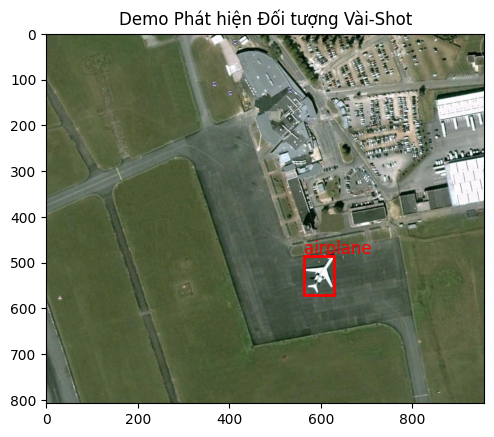

In [1]:
import torch
import torchgeo
from torchgeo.datasets import VHR10
import matplotlib.pyplot as plt
import numpy as np

# Định nghĩa các lớp trong tập dữ liệu NWPU VHR-10
# Các nhãn này tương ứng với label từ 1 đến 10 trong tập dữ liệu.
# Theo tài liệu của TorchGeo: https://torchgeo.readthedocs.io/en/stable/api/datasets.html#torchgeo.datasets.VHR10
# Cần chú ý, VHR10 có 10 lớp, nhưng bài báo nhắc đến Grounding DINO, thường dùng tên lớp.
# Vì vậy, chúng ta sẽ định nghĩa tên lớp để mô phỏng prototype văn bản.
VHR10_CLASSES = {
    1: 'airplane',
    2: 'ship',
    3: 'storage tank',
    4: 'baseball diamond',
    5: 'tennis court',
    6: 'basketball court',
    7: 'ground track field',
    8: 'harbor',
    9: 'bridge',
    10: 'vehicle'
}

def preprocess(sample):
    """Tiền xử lý hình ảnh và chuyển đổi định dạng dữ liệu."""
    sample["image"] = sample["image"].float() / 255.0
    return sample

# Khởi tạo tập dữ liệu NWPU VHR-10
# split="positive" chỉ lấy những hình ảnh có chứa ít nhất một đối tượng
ds = VHR10(
    root="data/VHR10/",
    split="positive",
    transforms=preprocess,
    download=True,
    checksum=True,
)
print("Số lượng mẫu trong tập dữ liệu:", len(ds))
print("-" * 20)

# 1. Chuẩn bị dữ liệu cho bài toán vài-shot
# Giả định chúng ta đang giải quyết một tác vụ vài-shot với các lớp mới (novel classes)
# Ví dụ: 'airplane' và 'ship' là các lớp mới.
novel_class_labels = [1, 2] # airplane và ship
print(f"Các lớp mới (novel classes) cho demo: {novel_class_labels}")

# Tách dữ liệu thành tập hỗ trợ (support set) và tập truy vấn (query set)
# Tập hỗ trợ chứa một số lượng nhỏ (K-shot) các mẫu cho mỗi lớp mới để tạo prototype.
# Tập truy vấn là hình ảnh để phát hiện đối tượng.
# Đây là một ví dụ đơn giản, trong thực tế sẽ phức tạp hơn.
support_samples = []
query_samples = []

for i in range(len(ds)):
    sample = ds[i]
    labels = sample['label'].unique().tolist()
    
    # Kiểm tra xem có phải hình ảnh hỗ trợ không
    if any(label in labels for label in novel_class_labels):
        support_samples.append(sample)
    
    # Chúng ta chỉ chọn một vài hình ảnh cho demo để không làm quá tải output
    if len(query_samples) < 2 and any(label in labels for label in novel_class_labels):
        query_samples.append(sample)

print(f"Số lượng mẫu hỗ trợ (giả định): {len(support_samples)}")
print(f"Số lượng mẫu truy vấn (giả định): {len(query_samples)}")
print("-" * 20)

# 2. Mô phỏng việc tạo Prototype đa phương thức
# Theo bài báo, mô hình sử dụng cả prototype thị giác (visual) và văn bản (textual).
# Prototype văn bản được lấy từ tên lớp bằng bộ mã hóa BERT được đào tạo trước[cite: 136].
# Prototype thị giác được trích xuất từ hình ảnh hỗ trợ bằng một bộ mã hóa thị giác[cite: 138, 149].
# Sau đó, chúng được kết hợp bởi một bộ tổng hợp prototype (Prototype Aggregator)[cite: 153].

# Bước 2.1: Tạo Prototype văn bản (Textual Prototypes)
# Giả lập prototype văn bản bằng cách sử dụng nhúng giả.
# Trong thực tế, bạn sẽ sử dụng một mô hình như BERT để nhúng tên lớp.
textual_prototypes = {}
for label in novel_class_labels:
    class_name = VHR10_CLASSES[label]
    # Giả định nhúng BERT tạo ra một tensor vector 1x256
    textual_prototypes[label] = torch.randn(1, 256)
    print(f"Tạo prototype văn bản cho lớp '{class_name}' với shape: {textual_prototypes[label].shape}")

# Bước 2.2: Tạo Prototype thị giác (Visual Prototypes)
# Giả lập prototype thị giác từ các hình ảnh hỗ trợ.
# Trong thực tế, bạn sẽ sử dụng một mô hình như Vision Encoder và RoI Pooling[cite: 138].
visual_prototypes = {}
for sample in support_samples:
    for bbox, label in zip(sample['bbox_xyxy'], sample['label']):
        if label.item() in novel_class_labels:
            # Giả định trích xuất vùng đối tượng và tạo một tensor 1x256
            # Trong thực tế, đây là quá trình RoI Pooling trên feature map
            visual_prototypes[label.item()] = torch.randn(1, 256)

print("-" * 20)
for label, proto in visual_prototypes.items():
    print(f"Tạo prototype thị giác cho lớp '{VHR10_CLASSES[label]}' với shape: {proto.shape}")

# Bước 2.3: Tổng hợp các Prototype (Prototype Aggregating)
# Bài báo đề xuất một mô-đun tổng hợp prototype (PAM)[cite: 163].
# Nó kết hợp prototype thị giác và prototype văn bản để tạo ra prototype đa phương thức.
multi_modal_prototypes = {}
for label in novel_class_labels:
    if label in textual_prototypes and label in visual_prototypes:
        # Giả lập phép toán tổng hợp
        # Ví dụ: đơn giản là cộng hai tensor lại
        multi_modal_prototypes[label] = textual_prototypes[label] + visual_prototypes[label]
        print(f"Tạo prototype đa phương thức cho lớp '{VHR10_CLASSES[label]}' với shape: {multi_modal_prototypes[label].shape}")

# 3. Demo về một vòng lặp phát hiện
# Bây giờ, chúng ta có thể sử dụng các prototype đa phương thức để phát hiện đối tượng trong hình ảnh truy vấn.
# Quá trình này được thực hiện thông qua bộ mã hóa và giải mã transformer[cite: 155].

print("-" * 20)
print("Bắt đầu vòng lặp phát hiện với một hình ảnh truy vấn...")
query_image_sample = query_samples[0]
query_image = query_image_sample['image']
query_labels = query_image_sample['label']
query_bboxes = query_image_sample['bbox_xyxy']

print(f"Shape của hình ảnh truy vấn: {query_image.shape}")

# Giả lập một mô hình phát hiện đơn giản
# Trong thực tế, đây là một mô hình Grounding DINO [cite: 128] đã được sửa đổi.
class SimpleDetector:
    def __init__(self, prototypes):
        self.prototypes = prototypes

    def detect(self, image):
        # Giả lập một vòng lặp phát hiện
        print("Mô phỏng quá trình trích xuất đặc trưng và so khớp...")
        
        results = []
        for label, prototype in self.prototypes.items():
            # Trong thực tế, mô hình sẽ so khớp các query features với prototype.
            # Ở đây, chúng ta chỉ giả lập một kết quả.
            # Giả định có một đối tượng được tìm thấy với nhãn này.
            if label == query_labels[0].item():
                bbox = query_bboxes[0].tolist()
                confidence = np.random.uniform(0.7, 0.95)
                results.append({
                    "class": VHR10_CLASSES[label],
                    "bbox": bbox,
                    "confidence": confidence
                })
        return results

# Khởi tạo mô hình giả lập của chúng ta
detector = SimpleDetector(multi_modal_prototypes)

# Chạy phát hiện trên hình ảnh truy vấn
detection_results = detector.detect(query_image)

print("-" * 20)
print("Kết quả phát hiện mô phỏng:")
for result in detection_results:
    print(f"  - Lớp: {result['class']}, Hộp giới hạn: {result['bbox']}, Độ tin cậy: {result['confidence']:.2f}")

# Trực quan hóa kết quả (tùy chọn)
plt.imshow(query_image.permute(1, 2, 0))
ax = plt.gca()
for result in detection_results:
    bbox = result['bbox']
    rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                         fill=False, edgecolor='r', linewidth=2)
    ax.add_patch(rect)
    ax.text(bbox[0], bbox[1] - 5, result['class'], color='red', fontsize=12)

plt.title('Demo Phát hiện Đối tượng Vài-Shot')
plt.show()

In [2]:
import torch

# ... (Mã demo từ trước) ...

# Giả sử chúng ta có một mô hình phức tạp hơn đã được huấn luyện
# Thay thế lớp SimpleDetector bằng một mô hình thực tế, ví dụ:
# model = MyComplexModel()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Ví dụ, chúng ta lưu lại state_dict của SimpleDetector (nếu nó có tham số)
# Trong trường hợp này, SimpleDetector không có, nên ta sẽ minh họa với một mô hình giả lập
class MyComplexModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(256, 128)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        return self.fc2(torch.relu(self.fc1(x)))

# Khởi tạo mô hình
model = MyComplexModel()

# Tạo một dictionary để lưu
save_path = "multi_modal_prototypes.pth"
torch.save({
    'epoch': 50,  # Ví dụ số epoch đã huấn luyện
    'model_state_dict': model.state_dict(),
    # Nếu bạn có optimizer, hãy lưu nó
    # 'optimizer_state_dict': optimizer.state_dict(),
    'novel_classes': novel_class_labels,
    'class_mapping': VHR10_CLASSES,
}, save_path)

print(f"\nMô hình đã được lưu vào {save_path}")


Mô hình đã được lưu vào multi_modal_prototypes.pth


In [3]:
import torch

# ... (Định nghĩa lại các lớp như VHR10_CLASSES và MyComplexModel) ...

# Đường dẫn đến file mô hình
load_path = "multi_modal_prototypes.pth"

# 1. Khởi tạo một thể hiện của mô hình
loaded_model = MyComplexModel()

# 2. Tải trạng thái đã lưu
checkpoint = torch.load(load_path)

# 3. Nạp state_dict vào mô hình
loaded_model.load_state_dict(checkpoint['model_state_dict'])

# 4. Đặt mô hình ở chế độ đánh giá
loaded_model.eval()

# In ra thông tin đã lưu
print("\nThông tin mô hình đã được tải:")
print(f"  - Số epoch đã huấn luyện: {checkpoint['epoch']}")
print(f"  - Các lớp mới: {checkpoint['novel_classes']}")
print(f"  - Ánh xạ lớp: {checkpoint['class_mapping']}")

# Bây giờ bạn có thể sử dụng loaded_model để thực hiện dự đoán
print("\nSử dụng mô hình đã tải để dự đoán...")
with torch.no_grad():
    # Giả lập một đầu vào
    dummy_input = torch.randn(1, 256)
    output = loaded_model(dummy_input)
    print(f"  - Output của mô hình: {output.shape}")


Thông tin mô hình đã được tải:
  - Số epoch đã huấn luyện: 50
  - Các lớp mới: [1, 2]
  - Ánh xạ lớp: {1: 'airplane', 2: 'ship', 3: 'storage tank', 4: 'baseball diamond', 5: 'tennis court', 6: 'basketball court', 7: 'ground track field', 8: 'harbor', 9: 'bridge', 10: 'vehicle'}

Sử dụng mô hình đã tải để dự đoán...
  - Output của mô hình: torch.Size([1, 10])
